In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from influxdb import InfluxDBClient
import requests
from datetime import datetime, timedelta
import json
import pytz

In [2]:
# See command on the line below to see why I am skipping lines
# !head -n 50 /home/chris/Data/tides/p046046a_2022-brisbane-bar_10min.csv
# data source: https://www.data.qld.gov.au/dataset/brisbane-bar-tide-gauge-predicted-interval-data
# licenced CC-BY-SA
df = pd.read_csv("/home/chris/Data/tides/p046046a_2022-brisbane-bar_10min.csv",skiprows=39)
df.columns = [c.strip() for c in df.columns]
del df["Ind"]

In [2]:
bne = pytz.timezone('Australia/Brisbane')

In [4]:
df["date"] = pd.to_datetime(df.apply(lambda r: "{} {}".format(r.Date, r.Time), axis=1))
del df["Date"]
del df["Time"]

In [5]:
# I'm keeping everything in Influx in UTC to make life easier
df["date"] = df["date"].apply(lambda d: d.tz_localize("Australia/Brisbane"))
#df["date"] = df["date"].apply(lambda d: d.tz_localize('UTC'))
df.set_index("date", inplace=True)

In [6]:
# Basic analysis 
# This info is in the header, I am just cross checking
dailies = df.resample('D')['Reading']
print("Average low {}".format(dailies.transform('min').mean()))
print("Average high {}".format(dailies.transform('max').mean()))
print("Median low {}".format(dailies.transform('min').mean()))
print("Average high {}".format(dailies.transform('max').mean()))
print("Time and height of year high\n{}".format(df.iloc[df.Reading.argmax()]))
print("Time and height of year low\n{}".format(df.iloc[df.Reading.argmin()]))
#df.Reading.min()triggered

Average low 0.5006520547945206
Average high 2.308178082191781
Median low 0.5006520547945206
Average high 2.308178082191781
Time and height of year high
Reading    2.756
Name: 2022-07-14 22:20:00+10:00, dtype: float64
Time and height of year low
Reading    0.219
Name: 2022-12-08 15:40:00+10:00, dtype: float64


In [7]:
df[0:120].min()

Reading    0.305
dtype: float64

In [8]:
df[(datetime.today()-timedelta(hours=12)).strftime('%Y-%m-%dT%H:%m:%S'):(datetime.today()+timedelta(hours=12)).strftime('%Y-%m-%dT%H:%m:%S')].plot()

/tmp/ipykernel_32953/442145767.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df[(datetime.today()-timedelta(hours=12)).strftime('%Y-%m-%dT%H:%m:%S'):(datetime.today()+timedelta(hours=12)).strftime('%Y-%m-%dT%H:%m:%S')].plot()


<AxesSubplot:xlabel='date'>

In [9]:
df.loc['2022-02-9T13:00Z00:00']
#pd.to_datetime("2022-02-09T10:00").tz_localize("Australia/Brisbane").tz_convert('UTC').strftime('%Y-%m-%dT%H:%m')

Reading
date                              
2022-02-09 10:00:00+10:00    1.191

In [3]:
client = InfluxDBClient(host='dashdot.local', port=8086)

In [4]:
#client.get_list_database()
#client.create_database('tides')

In [5]:
client.switch_database('tides')

In [6]:
def df_to_influx_json(df):
    return [{"measurement": "BOMpred",
            "time": pd.to_datetime(str(t)).strftime('%Y-%m-%dT%H:%m:%S'),
            "fields": {"height": val}} for val, t in zip(df.Reading.values, df.index.values)]
df_to_influx_json(df.iloc[0:2])

NameError: name 'df' is not defined

In [14]:
client.write_points(df_to_influx_json(df))

ConnectionError: HTTPConnectionPool(host='dashdot.local', port=8086): Max retries exceeded with url: /write?db=tides (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f09c1c6e310>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [53]:
client.query('SELECT "height" FROM "tides"."autogen"."BOMpred" WHERE time > now() - 4d')

NameError: name 'client' is not defined

In [55]:
url = 'https://www.data.brisbane.qld.gov.au/data/api/3/action/datastore_search?resource_id=78c37b45-ecb5-4a99-86b2-f7a514f0f447&limit=1000000'  
response = requests.get(url)
response

<Response [200]>

In [56]:
results = json.loads(response.text)
#pd.DataFrame.from_dict(results["result"]["records"])

In [57]:
# E1594	540286	Mouth of Breakfast Ck, Newstead
# E1525	540130	Mayne Railway Yards, Bowen Hills	Stream Height AHD
# E1524	540130	Mayne Railway Yards, Bowen Hills	Rainfall
# E1531	540118	Bancroft Park, Kelvin Grove	Stream Height AHD
# E1884	540799	Lugg Street, Bardon
# E1710	540804	Royal Pde, Ashgrove
lookup = {'E1594': 'BreakfastCkMouth',
 'E1525': 'BowenHillsStream',
 'E1524': 'BowenHillsRain',
 'E1531': 'BancroftPark',
 'E1884': 'Bardon',
 'E1710': 'Ashgrove',
 'E1575': 'GordonParkRain'}

# test code
# subset_results = []
# for data in results["result"]["records"]:
#     for k, v in lookup.items():
#         if data[k] != "-":
#             subset_results.append([pd.to_datetime(data["Measured"]).tz_localize("Australia/Brisbane").tz_convert('UTC'), float(data[k]), v])
# df = pd.DataFrame(subset_results, columns=["date", "measurement","location"])
# df["date"] = pd.to_datetime(df["date"])
# df.set_index("date", inplace=True)
# df[df["location"] == "BreakfastCkMouth"]["measurement"].plot()

In [58]:
influx_json = []
for data in results["result"]["records"]:
    date = pd.to_datetime(data["Measured"]).tz_localize("Australia/Brisbane").tz_convert('UTC').strftime('%Y-%m-%dT%H:%m:%S')
    for k, v in lookup.items():
        if data[k] != "-":
            influx_json.append({"measurement": v,"time": date, "fields": {"height": float(data[k])}})
#client = InfluxDBClient(host='dashdot.local', port=8086)
#client.switch_database('tides')
#client.write(influx_json)
influx_json

[{'measurement': 'BreakfastCkMouth',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 0.14}},
 {'measurement': 'BowenHillsRain',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 0.0}},
 {'measurement': 'BancroftPark',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 3.34}},
 {'measurement': 'Bardon',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 13.26}},
 {'measurement': 'Ashgrove',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 23.12}},
 {'measurement': 'GordonParkRain',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 0.0}},
 {'measurement': 'BowenHillsRain',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 0.0}},
 {'measurement': 'BancroftPark',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 3.36}},
 {'measurement': 'Bardon',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 13.28}},
 {'measurement': 'Ashgrove',
  'time': '2022-05-12T01:05:00',
  'fields': {'height': 23.16}},
 {'measurement': 'GordonParkRain',
  't

In [59]:
client = InfluxDBClient(host='dashdot.local', port=8086)
client.switch_database('tides')
client.write_points(influx_json)

True

In [23]:
client.query('SELECT "height" FROM "tides"."autogen"."BowenHillsRain" WHERE time > now() - 4d')

ResultSet({'('BowenHillsRain', None)': [{'time': '2022-05-09T22:05:00Z', 'height': 0.0}, {'time': '2022-05-09T23:05:00Z', 'height': 0.0}, {'time': '2022-05-10T00:05:00Z', 'height': 0.0}, {'time': '2022-05-10T01:05:00Z', 'height': 0.0}, {'time': '2022-05-10T02:05:00Z', 'height': 0.0}, {'time': '2022-05-10T03:05:00Z', 'height': 0.0}, {'time': '2022-05-10T05:05:00Z', 'height': 0.0}, {'time': '2022-05-10T06:05:00Z', 'height': 0.0}, {'time': '2022-05-10T07:05:00Z', 'height': 0.0}, {'time': '2022-05-10T08:05:00Z', 'height': 0.0}, {'time': '2022-05-10T09:05:00Z', 'height': 0.0}, {'time': '2022-05-10T10:05:00Z', 'height': 0.0}, {'time': '2022-05-10T11:05:00Z', 'height': 0.0}, {'time': '2022-05-10T12:05:00Z', 'height': 1.0}, {'time': '2022-05-10T13:05:00Z', 'height': 0.0}, {'time': '2022-05-10T14:05:00Z', 'height': 0.0}, {'time': '2022-05-10T15:05:00Z', 'height': 0.0}, {'time': '2022-05-10T16:05:00Z', 'height': 0.0}, {'time': '2022-05-10T17:05:00Z', 'height': 0.0}, {'time': '2022-05-10T18:05:00

In [24]:
df = pd.DataFrame.from_dict(influx_json)
df["height"] = df.fields.apply(lambda h: h["height"])
del df["fields"]
df["date"] = pd.to_datetime(df["time"])
del df["time"]
df.set_index("date", inplace=True)

<AxesSubplot:xlabel='date'>

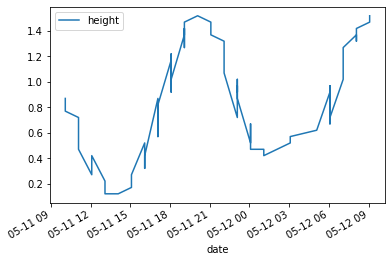

In [25]:
df[df["measurement"]=="BowenHillsStream"].plot()

In [15]:
import json
with open('influx2022flood.json', 'w') as f:
    json.dump(influx_json, f)

In [16]:
measure_table = []
for data in results["result"]["records"]:
    date = pd.to_datetime(data["Measured"]).tz_localize("Australia/Brisbane").tz_convert('UTC').strftime('%Y-%m-%dT%H:%m:%S')
    for k, v in lookup.items():
        if data[k] != "-":
            measure_table.append([v, date, float(data[k])])
df = pd.DataFrame(measure_table, columns=["measurement","date","value"])


In [4]:
from bs4 import BeautifulSoup
# They don't have a proper API because they seem to hate users
damn_url = "https://www.seqwater.com.au/dam-levels"
response = requests.get(damn_url)
response

<Response [200]>

In [6]:

soup = BeautifulSoup(response.text, "html.parser")

In [7]:
soup


<!DOCTYPE html>

<html dir="ltr" lang="en" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">
<head>
<meta charset="utf-8"/>
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-4839066-1"></script>
<script>window.dataLayer = window.dataLayer || [];function gtag(){dataLayer.push(arguments)};gtag("js", new Date());gtag("config", "UA-4839066-1", {"groups":"default","anonymize_ip":true,"allow_ad_personalization_signals":false});</script>
<link href="https://www.seqwater.com.au/dam-levels" rel="canonical"/>
<meta content="Latest information about South East Queensland's dam levels, average catchment rainfall and water consumption, as well as historical dam 

In [62]:
table = soup.find("table", {"class": "dam-levels-table table--sortable"})
data = []
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) 

In [64]:
columns = ["dam", "full", "current", "fullpct", "time", "status"]
df = pd.DataFrame(data, columns=columns)
df["dam"] = df.dam.apply(lambda d: d.split(" \n")[0])
df["time"] = df.time.apply(lambda t: pd.to_datetime(t).tz_localize("Australia/Brisbane").tz_convert('UTC').strftime('%Y-%m-%dT%H:%m:%S'))
num_cols = ["full", "current"]
for col in num_cols:
    df[col] = df[col].str.replace('\D+', '').astype(np.int64)
    
df["fullpct"] = df["fullpct"].str.replace('%','').astype(np.float64)
df

/tmp/ipykernel_27647/23302966.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace('\D+', '').astype(np.int64)


dam     full  current  fullpct  \
0                           Atkinson    30401    28494     93.7   
1                      Baroon Pocket    61000    65410    107.2   
2              Bill Gunn (Lake Dyer)     6947     7272    104.7   
3                            Borumba    46000    49319    107.2   
4                       Cedar Pocket      735      828    112.7   
5                          Clarendon    24276    22214     91.5   
6                        Cooloolabin     8183     8823    107.8   
7                           Enoggera     4262     6095    143.0   
8                       Ewen Maddock    16587    18898    113.9   
9                         Gold Creek      801     1447    180.7   
10                             Hinze   310730   326826    105.2   
11   Lake Macdonald (Six Mile Creek)     8018     8966    111.8   
12                   Lake Manchester    26217    29174    111.3   
13                   Leslie Harrison    13206    15373    116.4   
14                     Little Nerang     6705     6991    104.3   
15                            Maroon    44319    49269    111.2   
16                          Moogerah    83765   105296    125.7   
17                       Nindooinbah      208      256    122.9   
18      North Pine (Lake Samsonvale)   214302   151239     70.6   
19                             Poona      655      647     98.8   
20  Sideling Creek (Lake Kurwongbah)    14192    15897    112.0   
21                          Somerset   379849   327396     86.2   
22                             Wappa     4694     5287    112.6   
23                          Wivenhoe  1165240  1287450    110.5   
24                         Wyaralong   102883   121282    117.9   

                   time                               status  
0   2022-05-13T00:05:00                                 None  
1   2022-05-13T00:05:00                      Dam is spilling  
2   2022-05-12T22:05:00                      Dam is spilling  
3   2022-05-13T00:05:00                      Dam is spilling  
4   2022-05-13T00:05:00                      Dam is spilling  
5   2022-05-13T00:05:00                                 None  
6   2022-05-12T23:05:00                      Dam is spilling  
7   2022-05-13T00:05:00                      Dam is spilling  
8   2022-05-13T00:05:00                      Dam is spilling  
9   2022-05-13T00:05:00                      Dam is spilling  
10  2022-05-13T00:05:00                      Dam is spilling  
11  2022-05-13T00:05:00                      Dam is spilling  
12  2022-05-12T23:05:00                      Dam is spilling  
13  2022-05-12T23:05:00                      Dam is spilling  
14  2022-05-13T00:05:00                      Dam is spilling  
15  2022-05-12T22:05:00                   Releases occurring  
16  2022-05-13T00:05:00                      Dam is spilling  
17  2022-05-12T23:05:00                      Dam is spilling  
18  2022-05-13T00:05:00                   Releases occurring  
19  2022-05-12T23:05:00                                 None  
20  2022-05-12T22:05:00                      Dam is spilling  
21  2022-05-12T23:05:00  Utilising flood storage compartment  
22  2022-05-13T00:05:00                      Dam is spilling  
23  2022-05-12T22:05:00  Utilising flood storage compartment  
24  2022-05-12T23:05:00                      Dam is spilling

In [61]:
influx_json = []
for row in df[["dam", "time", "fullpct"]].to_dict('records'):
     influx_json.append({"measurement": row["dam"],
                         "time": row["time"],
                         "fields": {"height": row["fullpct"]}})
#influx_json

In [65]:
client = InfluxDBClient(host='dashdot.local', port=8086)
client.switch_database('tides')
client.write_points(influx_json)

True

In [77]:
name = "Wivenhoe"
old_dam = pd.read_csv("data/{}.csv".format(name))


In [80]:
old_dam["time"] = old_dam.Date.apply(lambda t: pd.to_datetime(t).tz_localize("Australia/Brisbane").tz_convert('UTC').strftime('%Y-%m-%dT%H:%m:%S'))
old_dam

Name        Date  Last Observation (%)  Last Observation (ML)  \
0     Wivenhoe  13-05-2017                  72.6              846063.12   
1     Wivenhoe  14-05-2017                  72.6              845980.23   
2     Wivenhoe  15-05-2017                  72.6              845400.25   
3     Wivenhoe  16-05-2017                  72.5              844737.83   
4     Wivenhoe  17-05-2017                  72.4              843827.73   
...        ...         ...                   ...                    ...   
1822  Wivenhoe  09-05-2022                  90.6             1055832.40   
1823  Wivenhoe  10-05-2022                  90.8             1057822.92   
1824  Wivenhoe  11-05-2022                  97.6             1137523.04   
1825  Wivenhoe  12-05-2022                 106.9             1245579.63   
1826  Wivenhoe  13-05-2022                 111.7             1301248.93   

                     time  
0     2017-05-12T14:05:00  
1     2017-05-13T14:05:00  
2     2017-05-14T14:05:00  
3     2017-05-15T14:05:00  
4     2017-05-16T14:05:00  
...                   ...  
1822  2022-09-04T14:09:00  
1823  2022-10-04T14:10:00  
1824  2022-11-04T14:11:00  
1825  2022-12-04T14:12:00  
1826  2022-05-12T14:05:00  

[1827 rows x 5 columns]

In [79]:
influx_json = []
for row in old_dam[["time", "Last Observation (%)"]].to_dict('records'):
     influx_json.append({"measurement": name,
                         "time": row["time"],
                         "fields": {"height": row["Last Observation (%)"]}})
client = InfluxDBClient(host='dashdot.local', port=8086)
client.switch_database('tides')
client.write_points(influx_json)

True